In [1]:
import tensorflow as tf
import numpy as np
from tfUtils import *
import matplotlib.pyplot as plt
import innvestigate

Using TensorFlow backend.


In [2]:
from keras.layers import Input, Activation, Dense, Flatten
from keras.models import Model

We will create a function that generates m training examples, in which each example is a n_x sized vector of Gaussian Noise, that in one of its features has 20 (which would imply class 1 for that training example), or -20 (which would imply class 2 for that example)

In [3]:
def generate_data(m, n_x, seed = 9):
    np.random.seed = seed
    X = np.random.randn(m, n_x)
    Y = np.zeros((m, 2))
    dist = np.random.randint(low = 0, high = n_x-1, size = m)
    for i in range(m):
        t = np.random.rand();
        if t < 0.5:
            X[i, dist[i]] = -20
            Y[i, 0] = 1
        elif t >= 0.5:
            X[i, dist[i]] = 20
            Y[i, 1] = 1
    return X, Y, dist

In [4]:
X_train, Y_train, dist = generate_data(40000, 100)

This function creates the Tensorflow placeholder for both, inputs and labels, which have size n_x and n_y respectively

In [5]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [None, n_x])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X, Y

This function initializes parameters for the MLP (weights and biases) and saves them in a dictionary.

In [6]:
def initialize_parameters(n_x, layers):
    parameters = {}
    lay = layers[:]
    lay.insert(0, n_x)
    for i in range(1, len(layers) + 1):
        parameters["W" + str(i)] = tf.get_variable("W" + str(i), [lay[i-1], lay[i]],
                                                  initializer = tf.contrib.layers.xavier_initializer())
        parameters["b" + str(i)] = tf.get_variable("b" + str(i), [1, lay[i]], 
                                                  initializer = tf.zeros_initializer())
    return parameters

In [7]:
def forward_propagation(A, W, b, activation):
    Z = tf.matmul(A, W) + b
    if activation == "relu":
        A = tf.nn.relu(Z)
    elif activation == "sigmoid":
        A = tf.nn.sigmoid(Z)
    elif activation == "tanh":
        A = tf.nn.tanh(Z)
    elif activation == "linear":
        A = Z
    return A

In [8]:
def compute_cost(Z, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y))
    return cost

Having created the previous functions, we can now define the function that will train our model, this function receives the training data and hyperparameters.

In [9]:
def tf_model(X_train, Y_train, layers, activations, epochs, batch_size, starting_rate, decay, lambd):
    tf.reset_default_graph()
    m, n_x = X_train.shape
    __, n_y = Y_train.shape
    X, Y = create_placeholders(n_x, n_y)
    parameter_list = []
    parameters = initialize_parameters(n_x, layers)
    A = X
    for i in range(1, len(layers) + 1):
        A = forward_propagation(A, parameters["W" + str(i)], parameters["b" + str(i)], activations[i - 1])
    cost = compute_cost(A, Y)
    hard_A = tf.argmax(tf.nn.softmax(A, axis = 1), axis = 1)
    acc = tf.reduce_mean(tf.cast(tf.equal(hard_A, tf.argmax(Y, axis = 1)), tf.float32))
    for i in range(1, len(layers) + 1):
        cost += lambd * tf.nn.l2_loss(parameters["W" + str(i)])
    global_steps = tf.Variable(0, trainable = False)
    learning_rate = tf.train.exponential_decay(starting_rate, global_steps, 5000, decay, staircase = True)
    train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost, global_step = global_steps)
    init = tf.global_variables_initializer()
    cost_list = []
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(epochs):
            minibatches = random_minibatches(X_train, Y_train, batch_size, seed = epoch)
            epoch_cost = 0
            for minibatch in minibatches:
                sess.run(train, feed_dict = {X : minibatch[0], Y : minibatch[1]})
                epoch_cost += sess.run(cost, feed_dict = {X : minibatch[0], Y : minibatch[1]}) / len(minibatches)
            cost_list.append(epoch_cost)        
            if epoch % 5 == 0:
                print(epoch_cost)
        parameter_names = ["W1", "b1", "W2", "b2", "W3", "b3", "W4", "b4"]
        for j in range(len(parameter_names)):
            parameter_list.append(sess.run(parameters[parameter_names[j]]))
        print("accuracy", sess.run(acc, feed_dict = {X : X_train, Y : Y_train}))
    sess.close()
    plt.plot(np.array(cost_list), '-b')
    plt.show()
    return parameter_list

In [10]:
layers = [200, 300, 100, 2]
activations = [["relu", "relu", "relu", "linear"], ["sigmoid", "sigmoid", "sigmoid", "linear"], ["tanh", "tanh", "tanh", "linear"]]
epochs = 30
batch_size = 32
starting_rate = 0.0003
decay = .9
lambd = 0

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

0.05465624279500919
1.2285528300367335e-05
3.4663798885468054e-07
1.0988114317278556e-08
7.450580152834618e-11
2.9802320611338475e-12
accuracy 1.0


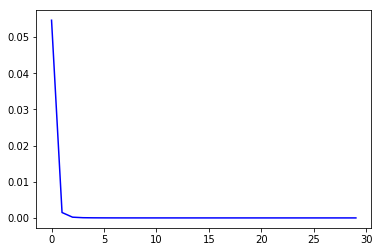

0.10747856737151754
4.7998629932044505e-05
1.8464352304590628e-06
7.165068072438892e-08
2.5570390320694865e-09
5.960464122267695e-12
0.0
accuracy 1.0


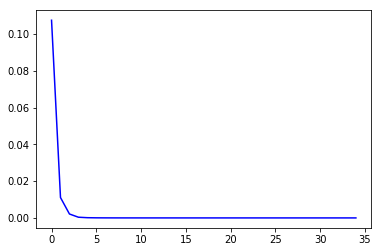

0.021191366752464042
3.37961309201091e-06
1.251277636017177e-07
4.222988590463202e-09
2.9802320611338475e-12
0.0
accuracy 1.0


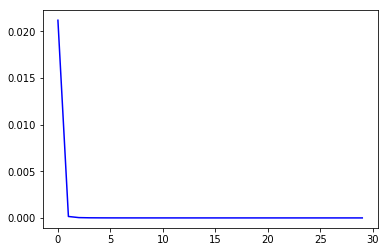

In [11]:
parameter_list_relu = tf_model(X_train, Y_train, layers, activations[0], epochs, batch_size, starting_rate, decay, lambd)
parameter_list_sigmoid = tf_model(X_train, Y_train, layers, activations[1], epochs + 5, batch_size, starting_rate, decay, lambd)
parameter_list_tanh = tf_model(X_train, Y_train, layers, activations[2], epochs, batch_size, starting_rate, decay, lambd)

In [12]:
X_train_ = X_train.reshape(-1, 10, 10, 1)
Y_train_ = Y_train.reshape(-1, 2)

In [13]:
def create_model(input_shape, layers, activations, use_soft):
    X_input = Input(input_shape)
    X = Flatten()(X_input)
    X = Dense(layers[0], activation = activations[0])(X)
    X = Dense(layers[1], activation = activations[1])(X)
    X = Dense(layers[2], activation = activations[2])(X)
    if use_soft :
        X = Dense(layers[3], activation = 'softmax')(X)
    else :
        X = Dense(layers[3], activation = 'linear')(X)
    model = Model(inputs = X_input, outputs = X)
    return model    

In [14]:
model_relu = create_model((10, 10, 1), layers, activations[0], False)
modelp_relu = create_model((10, 10, 1), layers, activations[0], True)
model_sigmoid = create_model((10, 10, 1), layers, activations[1], False)
modelp_sigmoid = create_model((10, 10, 1), layers, activations[1], True)
model_tanh = create_model((10, 10, 1), layers, activations[2], False)
modelp_tanh = create_model((10, 10, 1), layers, activations[2], True)

In [15]:
for i in range(len(parameter_list_relu)):
    if i % 2 == 1:
        parameter_list_relu[i] = parameter_list_relu[i].reshape(-1)
        parameter_list_tanh[i] = parameter_list_tanh[i].reshape(-1)
        parameter_list_sigmoid[i] = parameter_list_sigmoid[i].reshape(-1)

In [65]:
np.save('Model Weights and relevant parameters/relu_model_weights.npy', parameter_list_relu)
np.save('Model Weights and relevant parameters/sigmoid_model_weights.npy', parameter_list_sigmoid)
np.save('Model Weights and relevant parameters/tanh_model_weights.npy', parameter_list_tanh)

In [66]:
parameter_list_relu = np.load('Model Weights and relevant parameters/relu_model_weights.npy')
parameter_list_sigmoid = np.load('Model Weights and relevant parameters/sigmoid_model_weights.npy')
parameter_list_tanh = np.load('Model Weights and relevant parameters/tanh_model_weights.npy')

In [67]:
model_relu.set_weights(parameter_list_relu)
modelp_relu.set_weights(parameter_list_relu)
modelp_relu.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelp_relu.evaluate(x = X_train_, y = Y_train_)

40000/40000 [==============================] - 2s 38us/step


[1.1920930376163597e-07, 1.0]

In [68]:
model_sigmoid.set_weights(parameter_list_sigmoid)
modelp_sigmoid.set_weights(parameter_list_sigmoid)
modelp_sigmoid.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelp_sigmoid.evaluate(x = X_train_, y = Y_train_)

40000/40000 [==============================] - 2s 40us/step


[1.1920930376163597e-07, 1.0]

In [69]:
model_tanh.set_weights(parameter_list_tanh)
modelp_tanh.set_weights(parameter_list_tanh)
modelp_tanh.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelp_tanh.evaluate(x = X_train_, y = Y_train_)

40000/40000 [==============================] - 2s 40us/step


[1.1920930376163597e-07, 1.0]

In [49]:
analyzer_relu = innvestigate.create_analyzer("lrp.alpha_2_beta_1_IB", model_relu)
analyzer_sigmoid = innvestigate.create_analyzer("lrp.alpha_2_beta_1", model_sigmoid)
analyzer_tanh = innvestigate.create_analyzer("lrp.alpha_2_beta_1", model_tanh)

In [50]:
analysis_relu = analyzer_relu.analyze(X_train_[0:100,:])
analysis_sigmoid = analyzer_sigmoid.analyze(X_train_[0:100,:])
analysis_tanh = analyzer_tanh.analyze(X_train_[0:100,:])

In [51]:
rel_me = np.zeros((len(dist), 100))
for i in range(len(dist)):
    rel_me[i, dist[i]] = 1

In [52]:
rel_me = np.reshape(rel_me, (-1, 10, 10)) 

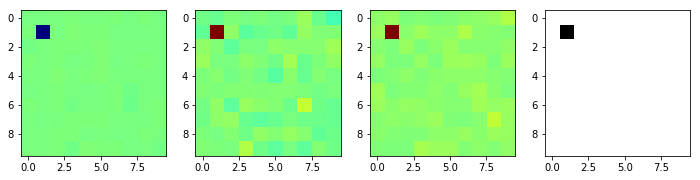

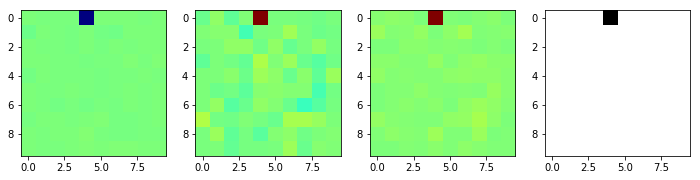

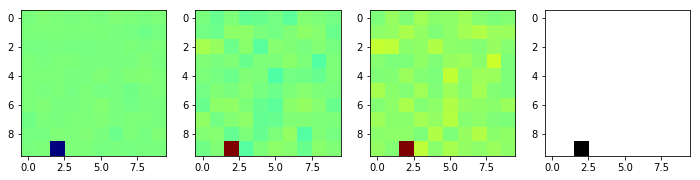

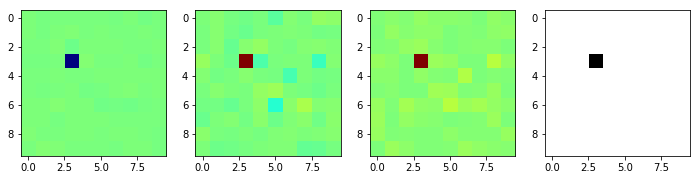

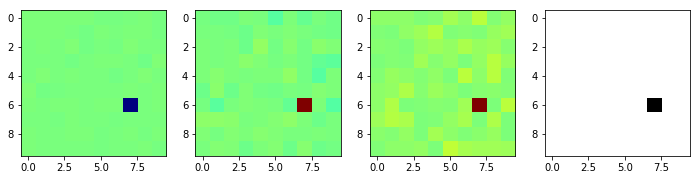

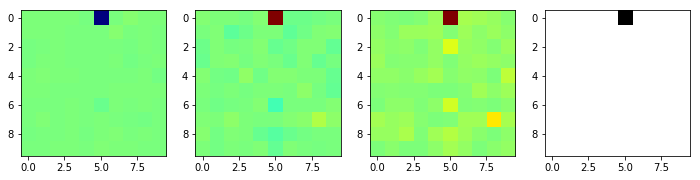

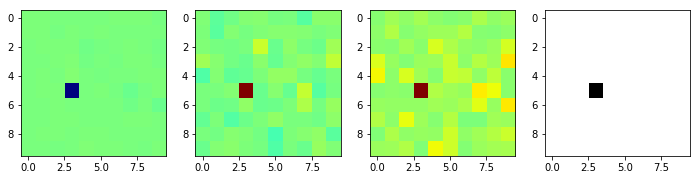

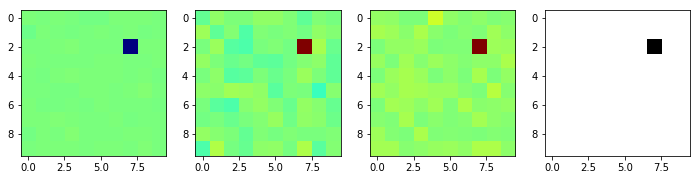

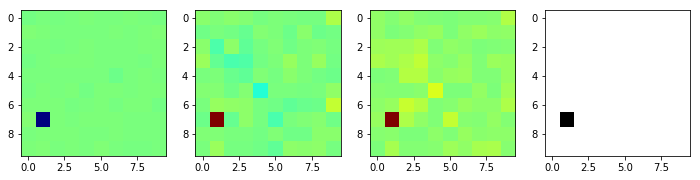

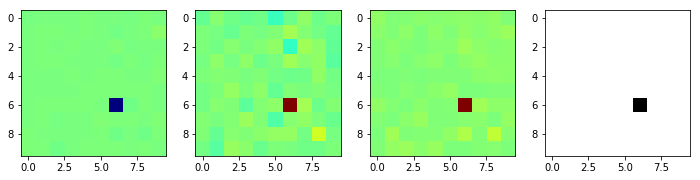

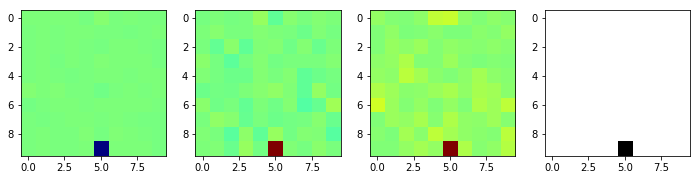

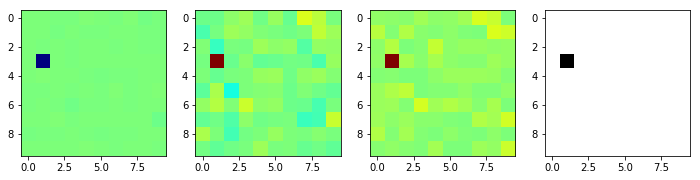

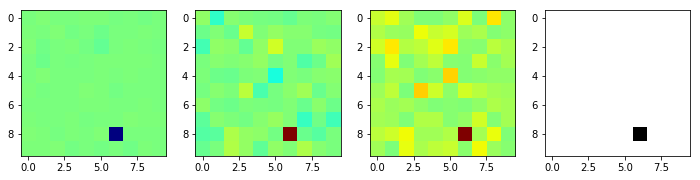

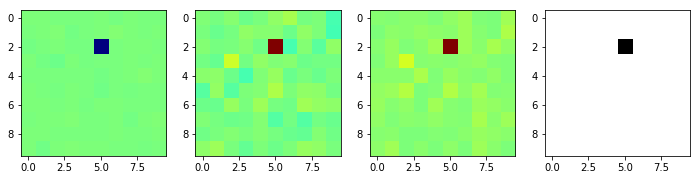

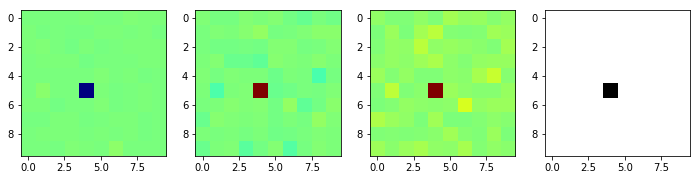

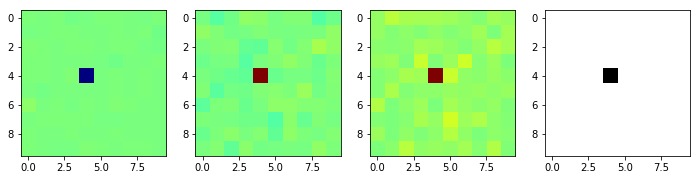

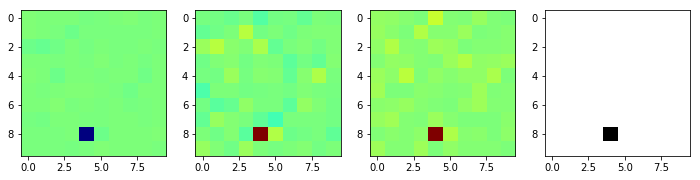

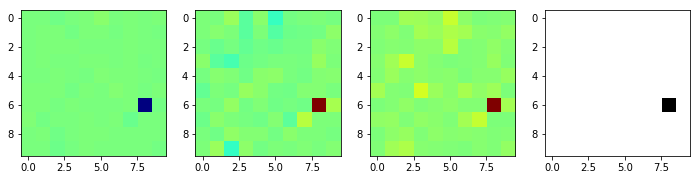

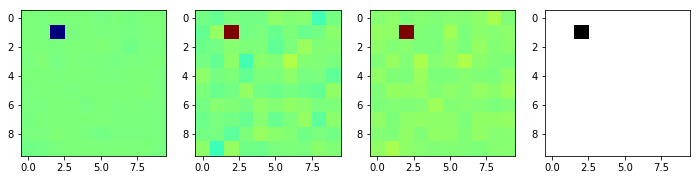

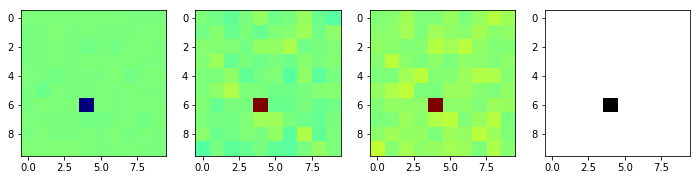

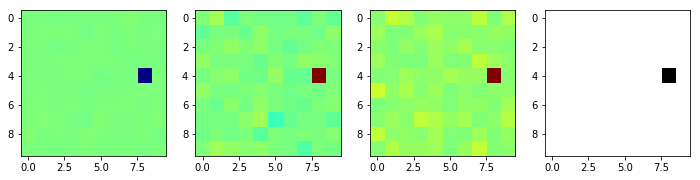

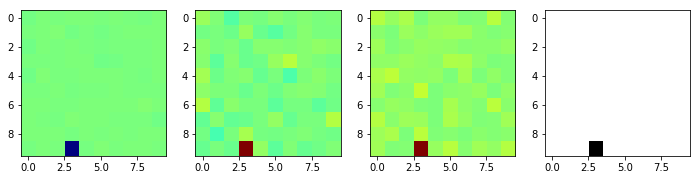

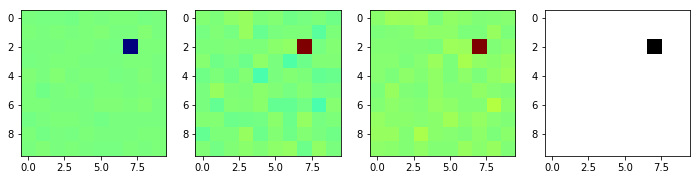

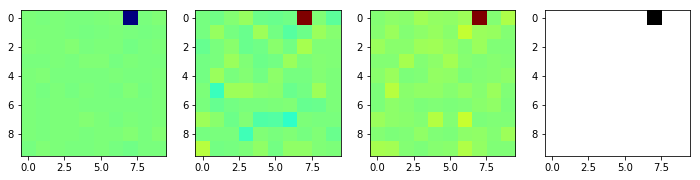

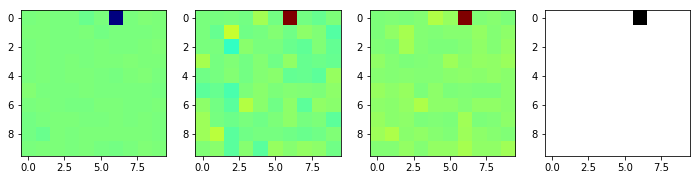

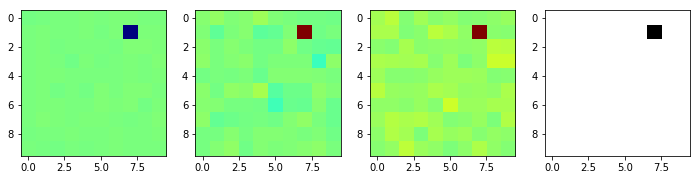

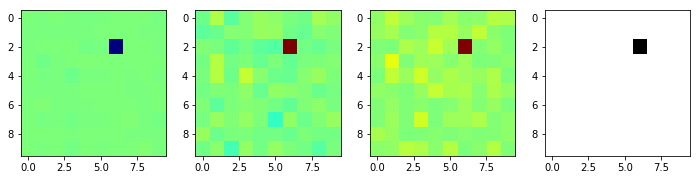

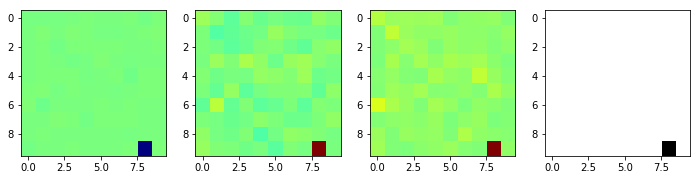

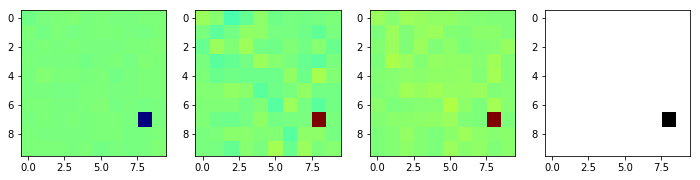

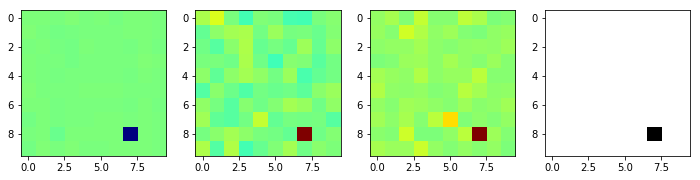

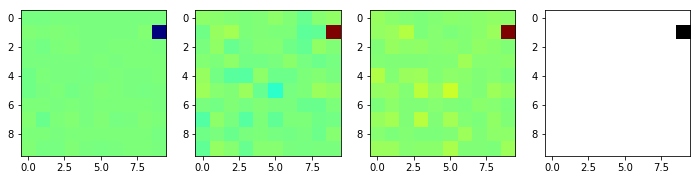

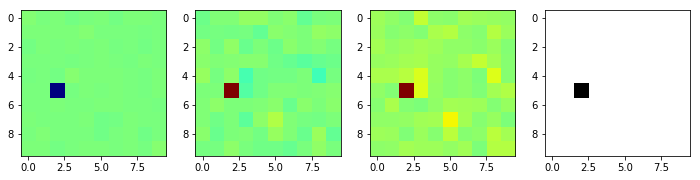

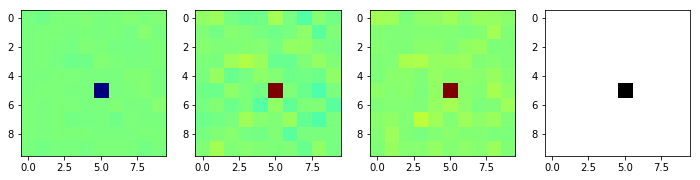

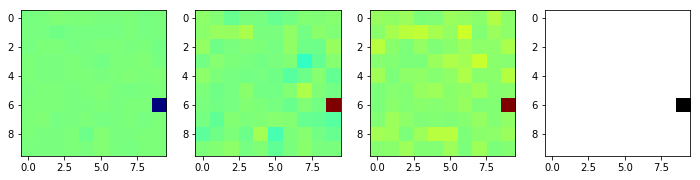

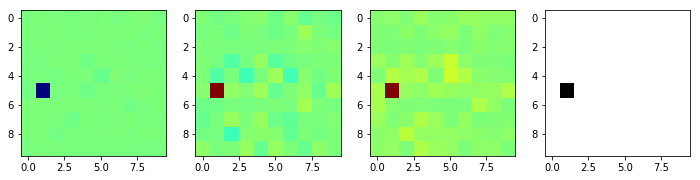

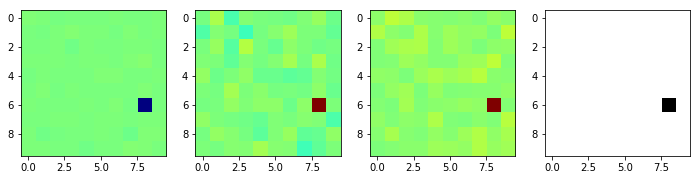

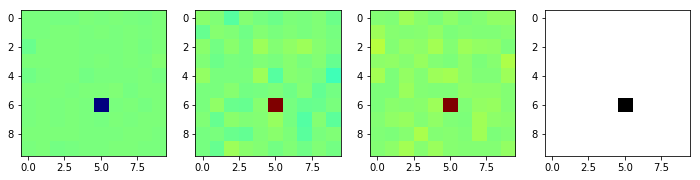

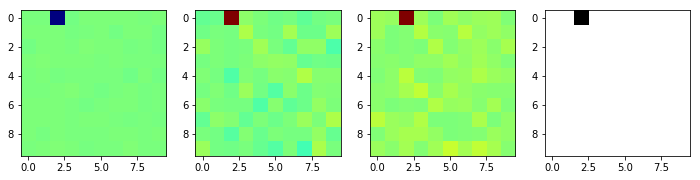

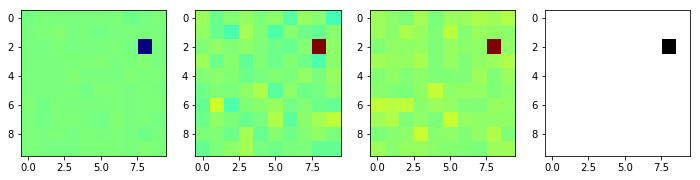

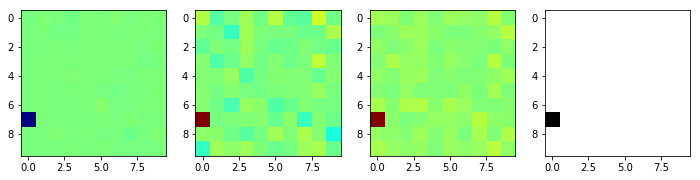

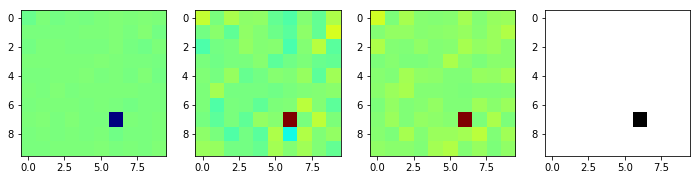

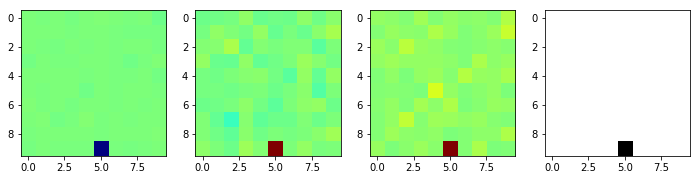

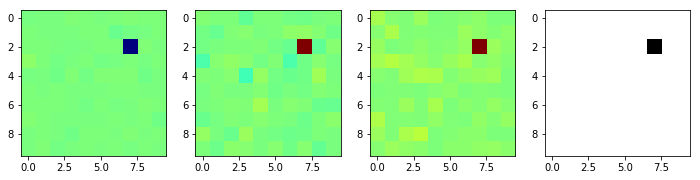

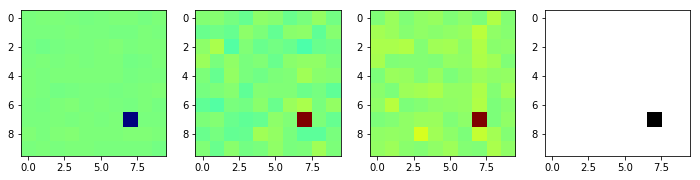

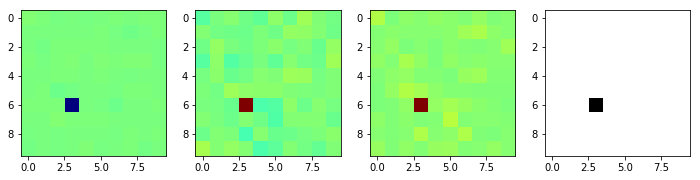

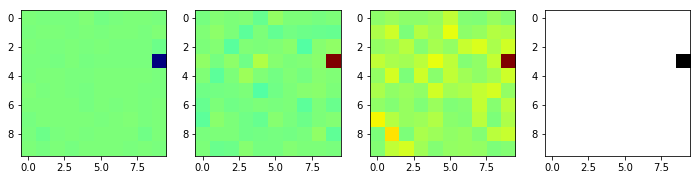

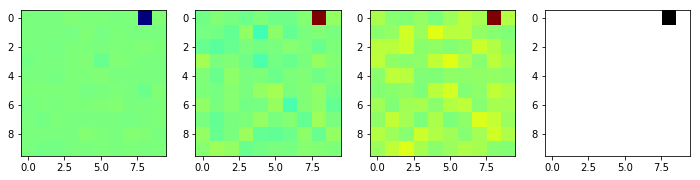

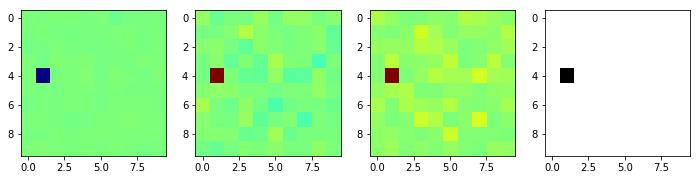

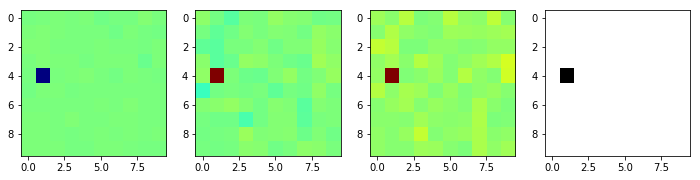

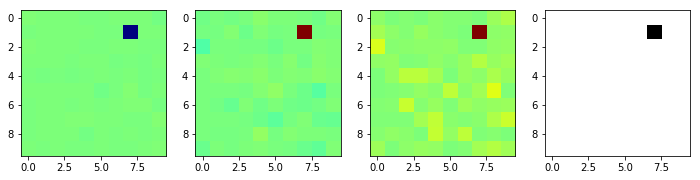

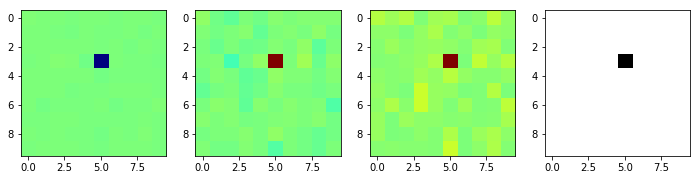

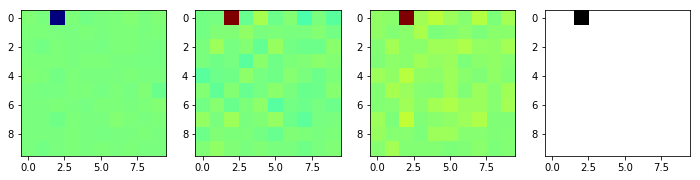

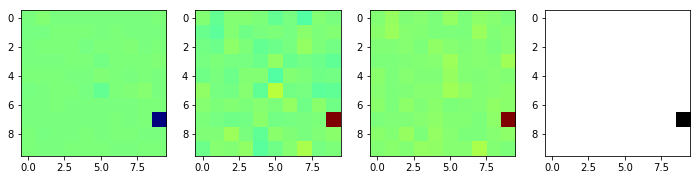

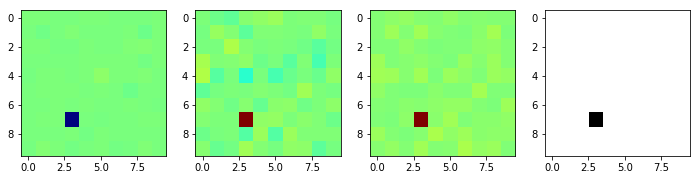

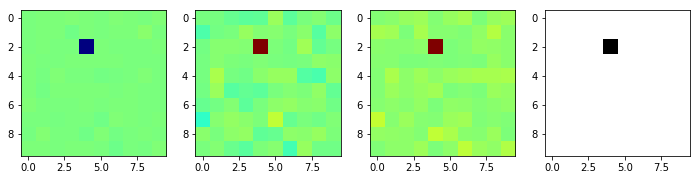

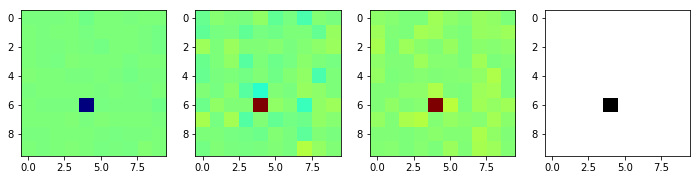

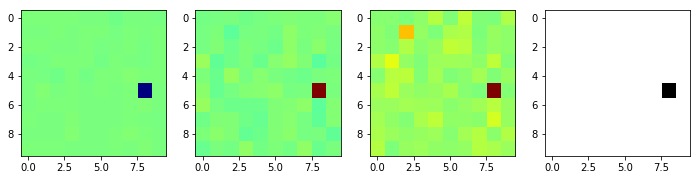

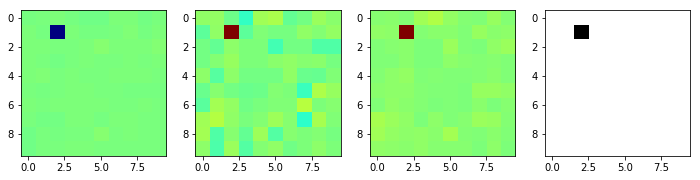

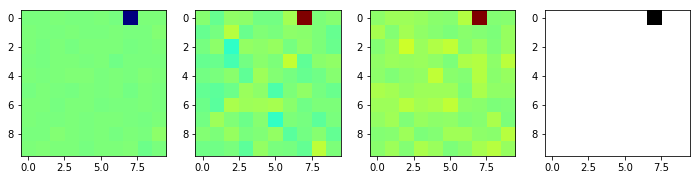

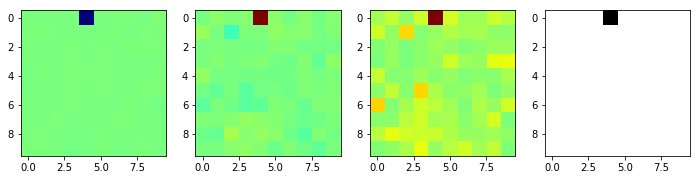

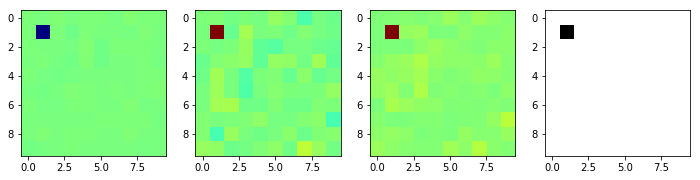

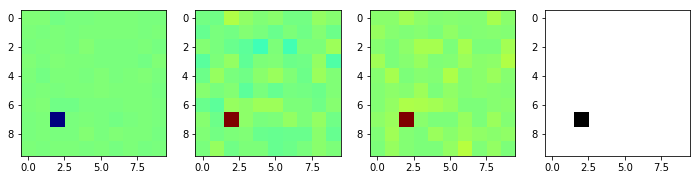

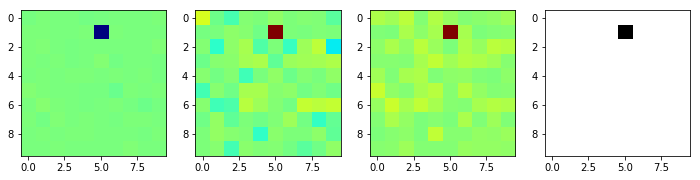

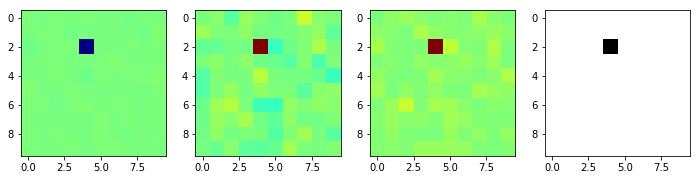

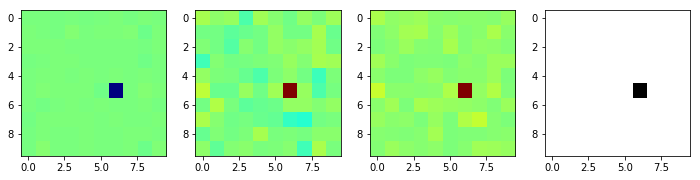

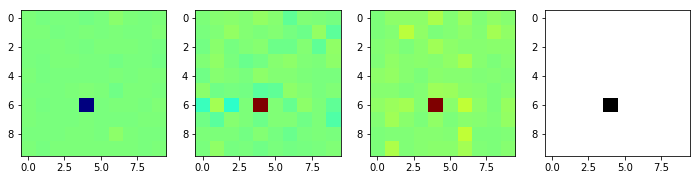

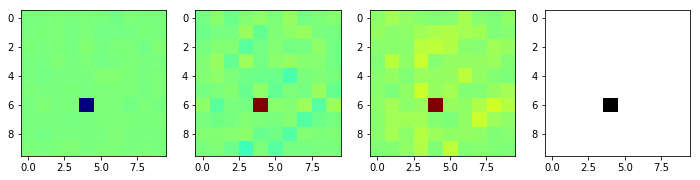

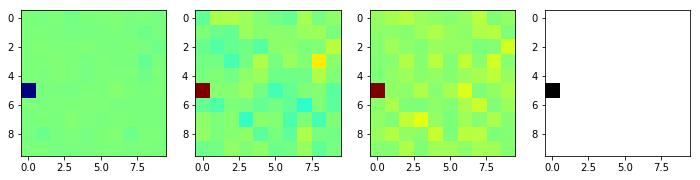

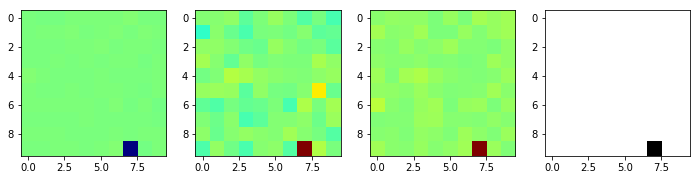

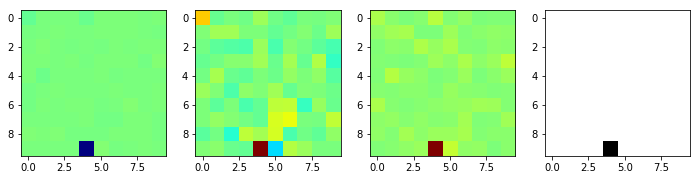

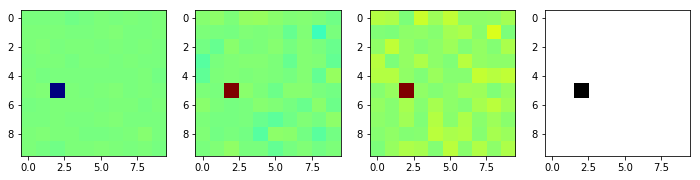

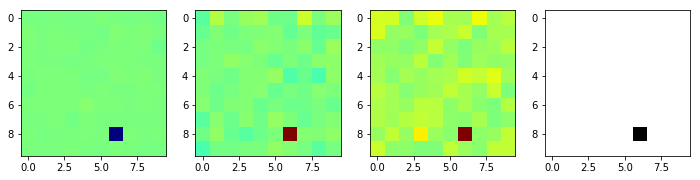

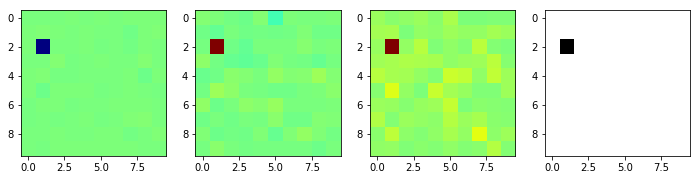

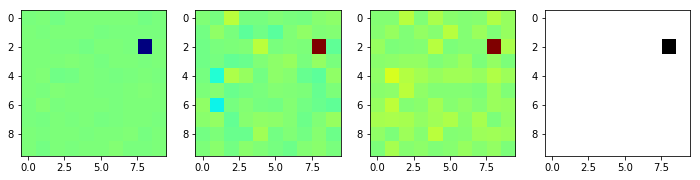

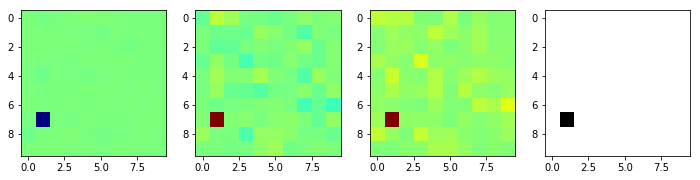

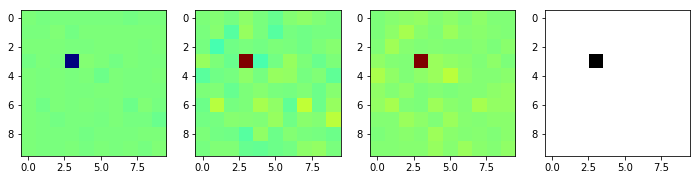

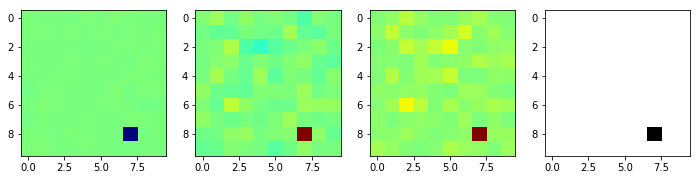

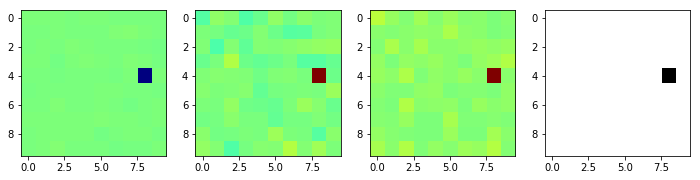

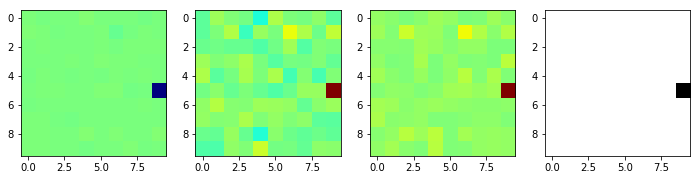

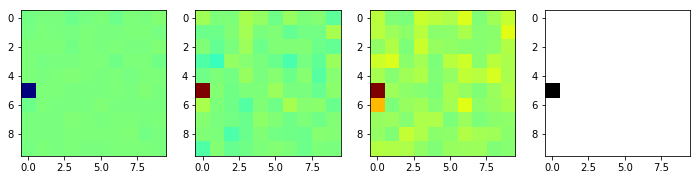

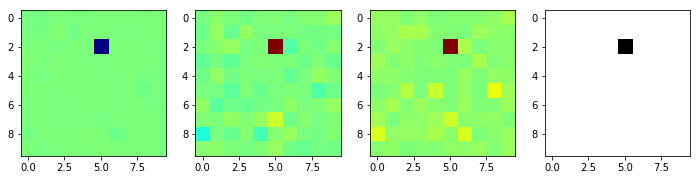

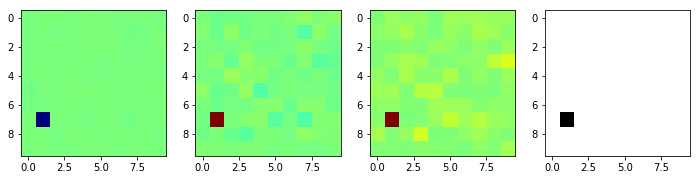

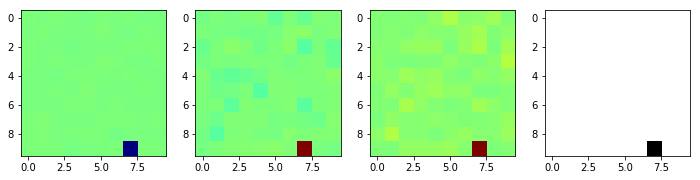

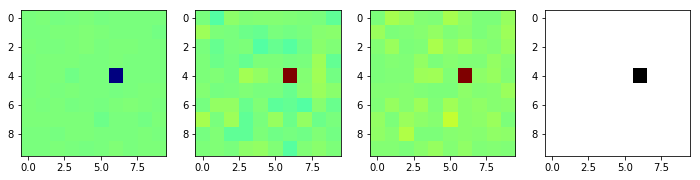

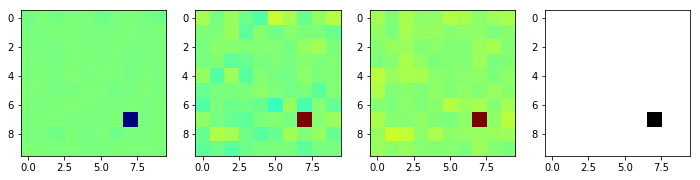

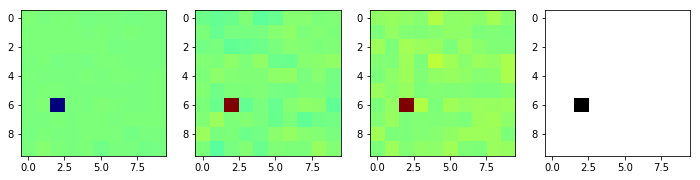

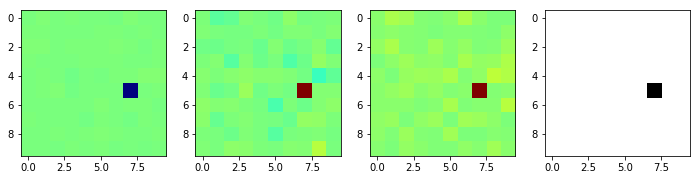

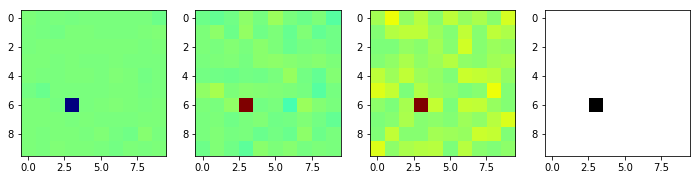

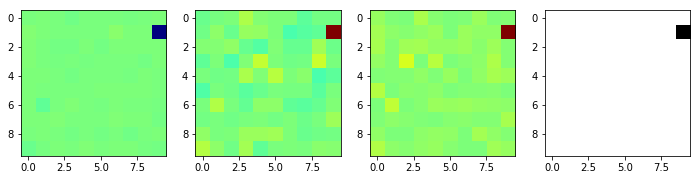

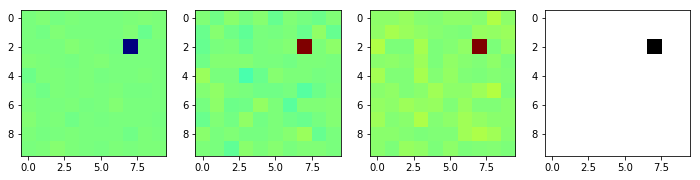

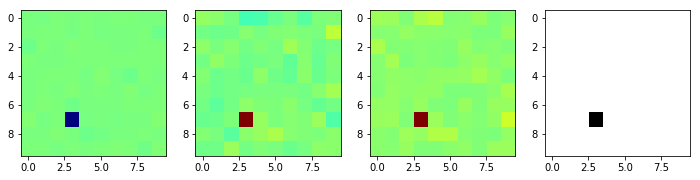

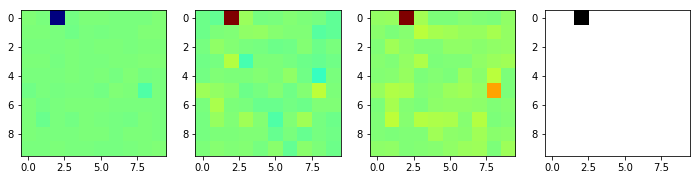

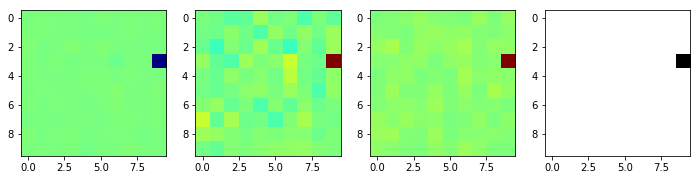

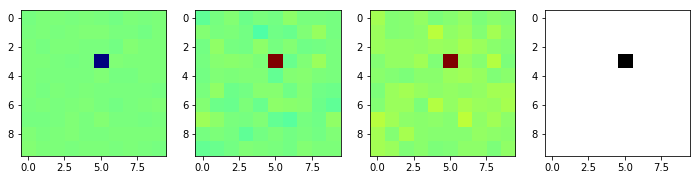

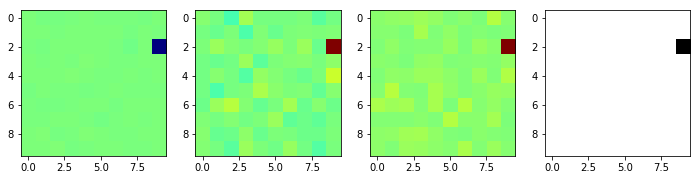

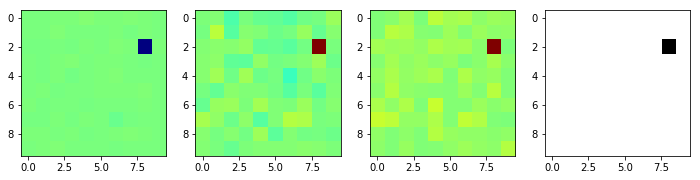

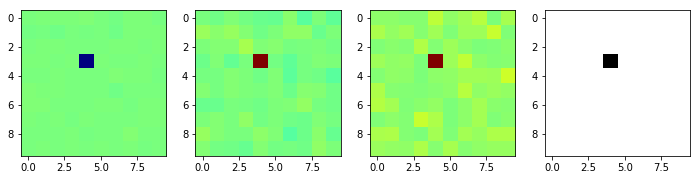

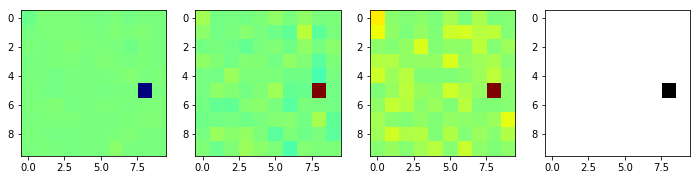

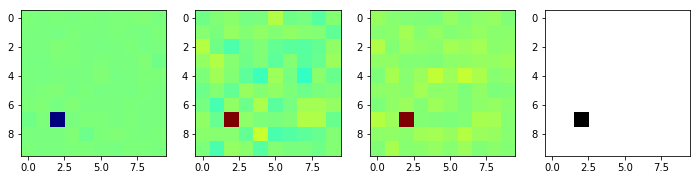

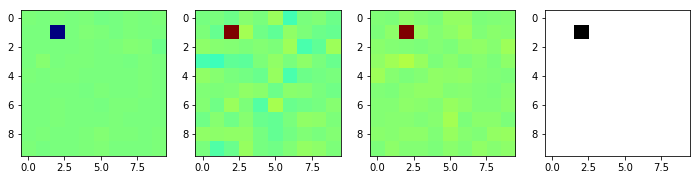

In [53]:
plt.close()
for i in range(100):
    f, axarr = plt.subplots(1, 4, figsize=(12, 12))
    
    m_relu = np.max(np.abs(analysis_relu[i,:,:,0]))
    a_relu = ((analysis_relu[i,:,:,0] / m_relu) + 1) / 2
    
    m_sigmoid = np.max(np.abs(analysis_sigmoid[i,:,:,0]))
    a_sigmoid = ((analysis_sigmoid[i,:,:,0] / m_sigmoid) + 1) / 2
    
    m_tanh = np.max(np.abs(analysis_tanh[i,:,:,0]))
    a_tanh = ((analysis_tanh[i,:,:,0] / m_tanh) + 1) / 2
    
    fig = axarr[0].imshow(a_relu, vmax = 1, vmin = 0, cmap = "jet")
    fig = axarr[1].imshow(a_sigmoid, vmax = 1, vmin = 0, cmap = "jet")
    fig = axarr[2].imshow(a_tanh, vmax = 1, vmin = 0, cmap = "jet")
    fig = axarr[3].imshow(rel_me[i,:,:], cmap = "binary")
plt.show()